In [1]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import csv
import random

import sklearn
from sklearn.cluster import KMeans
!pwd
!pip install hmmlearn

## PRIVATE
from copy import deepcopy
N_classes = 3

/content


In [2]:
fpath = "/content/HMMdata.csv"

def file_reader(fpath):
  filep = open(fpath, 'rt')
  reader = csv.reader(filep, delimiter=',')
  return np.array(list(reader))

data = file_reader(fpath)
data = data.astype(np.float64)

(200, 2)


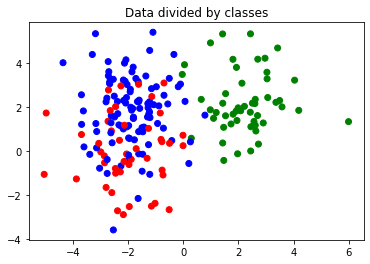

In [3]:
colormap = np.array(['r', 'g', 'b'])
X = np.array(list(map(int, data[:, 0])))
Y = np.array(data[:, 1:])
print(Y.shape)
y1, y2 = np.array(data[:, 1]), np.array(data[:, 2])
plt.scatter(y1, y2, c=colormap[X])
plt.title('Data divided by classes')
plt.show()

In [4]:
from math import pow, sqrt, log
def add_noise_gaussian(eps, delta, sensitivity, size=1):
    # Add 1D noise to data
    # Need to precalculate per data epsilon value
    constant = np.sqrt(2*np.log(1.25/delta))
    sigma = (constant*sensitivity)/eps
    #print('std:', sigma, 'Noise:', np.random.normal(loc=0, scale=sigma))
    if size == 1:
        return np.random.normal(loc=0, scale=sigma, size=size)[0]
    #elif type(size) == int:
    return np.random.normal(loc=0, scale=sigma, size=size)
    #else:

    #elif len(size) > 1:
    #    return np.random.normal(loc=0, sigma=sigma, )

def add_noise(eps, delta, sensitivity, size=1):
    #constant = np.sqrt(2*np.log(1.25/delta))
    sigma = sensitivity/eps
    if size == 1:
        return np.random.laplace(loc=0, scale=sigma, size=size)[0]
    #elif type(size) == int:
    return np.random.laplace(loc=0, scale=sigma, size=size)
    #else:

# Test Noise
x = 1
print(x, x+add_noise(eps=1, delta=0.01, sensitivity=1))
y = np.array([1, 2])
print(y, y+add_noise(eps=1, delta=0.01, sensitivity=1, size=2))
z = np.array([[1, 2], [3, 4]])
print(z, add_noise(eps=1, delta=0.01, sensitivity=1, size=(2, 2)))

1 0.9679627808911595
[1 2] [1.38206553 0.55974184]
[[1 2]
 [3 4]] [[-0.29128849 -0.00581803]
 [-1.88831237 -2.6707315 ]]


In [5]:
def clip(x, bound):
    den = max(1, np.linalg.norm(x, 1)/bound)
    output = x/den
    #print('Output Norm:', np.linalg.norm(output))
    return output

def clip_gaussian(x, bound):
    den = max(1, np.linalg.norm(x)/bound)
    output = x/den
    #print('Output Norm:', np.linalg.norm(output))
    return output

print(np.linalg.norm(clip(y, 1), 1))

1.0


In [6]:
from math import exp, log
def advanced_composition(eps, delta, iterations):
    delta_prime = delta
    term1=iterations*eps*(exp(eps)-1)
    term2=eps*sqrt(2*iterations*log(1/delta_prime))

    return term1+term2, iterations*delta+delta_prime # eps, delta 

In [7]:
advanced_composition(0.1, 0.005, 24)

(1.8471491588043714, 0.125)

In [8]:
# Privatized K-Means with Gaussian Noise
from copy import deepcopy
class private_KMeans:
    def __init__(self, data, Y_main, X, N_classes, d, tol=0.01, private=False, clip_bound = 4, eps = 1, delta = 1./200, max_iters=10):
        self.N_classes = N_classes # no. of classes
        self.data = data # complete
        self.tol = tol # tolerance for convergence
        self.N = Y.shape[0] # No of samples
        self.Y = deepcopy(Y_main) # data
        self.X = X # labels
        self.clip_bound = clip_bound
        self.d = d # dimensions of the data
        self.private = private # do we want to privatize?
        self.prev_centroids = None
        self.max_iters = max_iters # maximum iterations until convergence
        self.privacy_cost = {'eps':0.0, 'delta':0.0}
        self.privacy_counts = 0
        self.eps = eps
        self.delta = delta
        self.Y_original = deepcopy(self.Y)
        self.priors = np.zeros(self.N_classes)

        # Randomly initialize centroids
        # TODO: Matters a lot
        self.centroids = np.array([np.random.uniform(-self.clip_bound/self.d, self.clip_bound/self.d, self.d) for _ in range(self.N_classes)])
        if self.private:
            for k in range(self.N_classes):
                self.centroids[k, :] = deepcopy(clip_gaussian(self.centroids[k, :], self.clip_bound))
        #self.centroids = Y[np.random.choice(range(X.shape[0]), replace = False, size = self.N_classes), :]
        print('Initialization')
        print(self.centroids)

    

    def run(self):

        if self.private: #PRIVATE
            for n in range(self.N):
                self.Y[n] = deepcopy(clip_gaussian(self.Y[n], self.clip_bound))

            plt.figure()
            plt.scatter(self.Y[:, 0], self.Y[:, 1])
            plt.title('Clipped with norm bound:'+str(self.clip_bound))
            plt.show()

        for iterations in range(self.max_iters):
            votes = []
            for n in range(self.N): # This can be done privately
                distances = []
                for k in range(self.N_classes):
                    distances.append(np.linalg.norm(self.Y[n]-self.centroids[k, :]))
                votes.append(distances.index(min(distances))) # vote on the centroid which data n chooses

            #print(votes)

            # Get new centroids
            self.prev_centroids = deepcopy(self.centroids)

            for k in range(self.N_classes): 
                num = 0.
                den = 0.
                for n in range(self.N):
                    if votes[n] == k:
                        num+=self.Y[n]
                        den+=1
                
                sensitivity_num = np.sqrt(self.clip_bound)
                sensitivity_den = 1
                if self.private: #PRIVATE
                    num += add_noise_gaussian(self.eps, self.delta, sensitivity=sensitivity_num, size=self.d)
                    den += add_noise_gaussian(self.eps, self.delta, sensitivity=sensitivity_den, size=1) # only add positive noise
                    self.privacy_counts+=(1+self.d)
                self.priors[k]=den/self.N
                #privacy_cost['eps']+=2*self.eps
                #privacy_cost['delta']+=2*self.delta
                #print('NUM/DEN', num, den)

                if den > 0:
                    #print('ZERO')
                    self.centroids[k, :] = num/den 
                else:
                    self.centroids[k, :] = num

                if self.private:
                    for k in range(self.N_classes):
                        self.centroids[k, :] = deepcopy(clip_gaussian(self.centroids[k, :], self.clip_bound))
                # else centroids do not change
            #print('Old', self.prev_centroids)
            #print('New', self.centroids)
            # Stopping Condition
            if iterations > 2 and np.linalg.norm(self.centroids-self.prev_centroids) < self.tol:
                print('Iterations Required:', iterations+1)
                print('KMeans Converged')
                break
        if iterations == self.max_iters-1:
            print('Maximum Iterations Done')
            print('Iterations Required:', iterations+1)

        kmeans = KMeans(N_classes).fit(self.Y_original)
        means = kmeans.cluster_centers_

        # Compute priors
        #self.priors = 

        #if self.private:

        #print(means)
        #print(self.centroids)

        if self.private:
            print('Total eps/delta', advanced_composition(self.eps, self.delta, self.privacy_counts))
            print('Total privacy mechanisms', self.privacy_counts)

        plt.figure()
        y1, y2 = np.array(self.data[:, 1]), np.array(self.data[:, 2])
        plt.scatter(y1, y2, c=colormap[X], alpha=0.2)
        plt.scatter(means[:, 0], means[:, 1], s=200, c='m', marker='X', label='In-Built Function')
        plt.scatter(self.centroids[:, 0], self.centroids[:, 1], s=200, c='c', marker='^', label='Simulation')
        plt.title('KMeans: Data divided by classes')
        plt.legend()
        plt.show()       
          


Initialization
[[ 0.23778416 -0.43505494]
 [ 1.81030571 -0.06868272]
 [ 0.92226544 -1.18577445]]
Iterations Required: 10
KMeans Converged


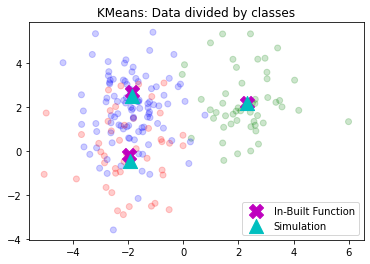

Epsilon: 1
Initialization
[[-0.05384042  0.78621177]
 [ 0.87462646  0.78768471]
 [ 1.21253817 -0.38243996]]


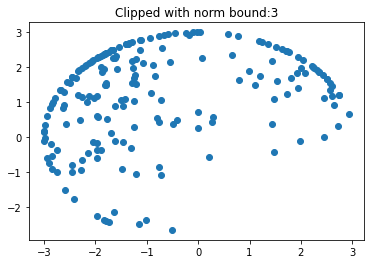

Maximum Iterations Done
Iterations Required: 4
Total eps/delta (81.38962939315037, 0.185)
Total privacy mechanisms 36


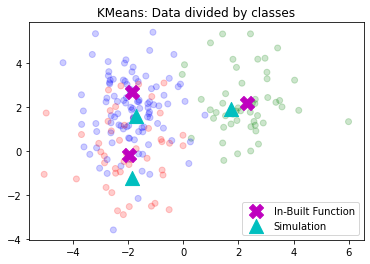

Priors [0.56478056 0.2732432  0.14523596]
Epsilon: 0.5
Initialization
[[-0.72855437 -0.83165874]
 [-0.88685032 -0.34586376]
 [ 0.91137207  0.32015576]]


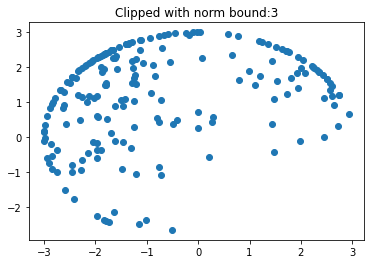

Maximum Iterations Done
Iterations Required: 4
Total eps/delta (21.442724656914685, 0.185)
Total privacy mechanisms 36


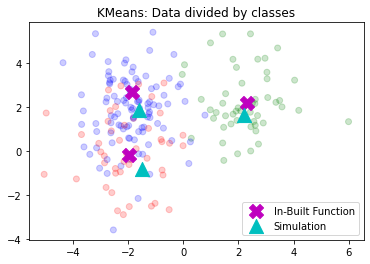

Priors [0.2720901  0.52727638 0.22971567]
Epsilon: 0.2
Initialization
[[-0.0666697   0.3498084 ]
 [ 0.20960959  0.5889362 ]
 [-0.40411457  0.22262836]]


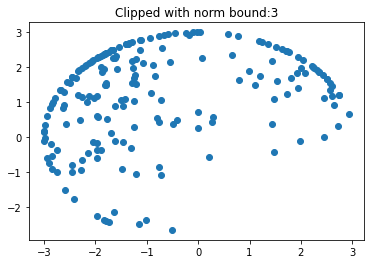

Maximum Iterations Done
Iterations Required: 4
Total eps/delta (5.500396572478174, 0.185)
Total privacy mechanisms 36


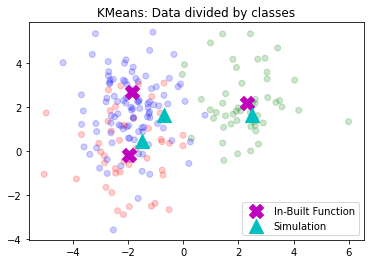

Priors [0.09940347 0.40131495 0.6058224 ]
Epsilon: 0.1
Initialization
[[ 1.06959167 -0.91273309]
 [ 1.32319711 -1.02268105]
 [-0.5250435  -0.42971897]]


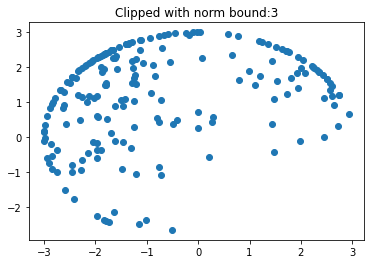

Maximum Iterations Done
Iterations Required: 4
Total eps/delta (2.331763661934807, 0.185)
Total privacy mechanisms 36


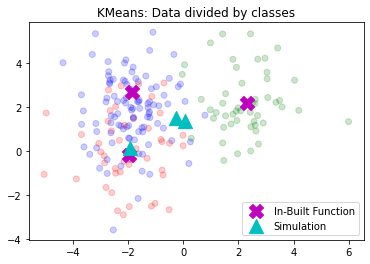

Priors [0.31348325 0.41265712 0.45934536]


In [9]:
kmeans = private_KMeans(data, Y, X, N_classes=3, d=2, tol=0.00001, private=False, max_iters=20)
kmeans.run()

#print(Y.shape)
#plt.scatter(Y[:, 0], Y[:, 1])
#plt.show()

print('Epsilon: 1')
kmeans = private_KMeans(data, Y, X, N_classes=3, d=2, tol=0.00001, private=True, clip_bound = 3, eps = 1, delta = 1./200, max_iters=4)
kmeans.run()
print('Priors', kmeans.priors)
#plt.scatter(Y[:, 0], Y[:, 1])
#plt.show()

print('Epsilon: 0.5')
kmeans = private_KMeans(data, Y, X, N_classes=3, d=2, tol=0.00001, private=True, clip_bound = 3, eps = 0.5, delta = 1./200, max_iters=4)
kmeans.run()
print('Priors', kmeans.priors)

#plt.scatter(Y[:, 0], Y[:, 1])
#plt.show()

print('Epsilon: 0.2')
kmeans = private_KMeans(data, Y, X, N_classes=3, d=2, tol=0.00001, private=True, clip_bound = 3, eps = 0.2, delta = 1./200, max_iters=4)
kmeans.run()
print('Priors', kmeans.priors)

print('Epsilon: 0.1')
kmeans = private_KMeans(data, Y, X, N_classes=3, d=2, tol=0.00001, private=True, clip_bound = 3, eps = 0.1, delta = 1./200, max_iters=4)
kmeans.run()
print('Priors', kmeans.priors)

In [10]:
# Original GMM 


'''
Expectation Maximization for the Gaussian Mixture Models.

'''

class GMM_EM:
    def __init__(self, N_classes, data, Y_main, X, d=2, max_iters = 5, private=False, clip_bound = 4, eps = 1, delta = 0.01, tol=0.01):
        # K-Means clustering to get centers for mean estimation
        kmeans = KMeans(N_classes).fit(Y)
        labels = kmeans.labels_
        data0 = Y[np.where(labels==0), :][0]
        data1 = Y[np.where(labels==1), :][0]
        data2 = Y[np.where(labels==2), :][0]
        self.max_iters = max_iters
        self.Y = np.array(deepcopy(Y_main), dtype=np.float128)
        self.d = d
        self.tol = tol
        self.N_classes = N_classes
        self.N = Y.shape[0]

        # ----------------------------------------
        # PRIVACY PARAMETERS
        # ----------------------------------------

        self.private = private
        self.privacy_counts = 0
        self.eps = eps
        self.delta = delta
        self.clip_bound = clip_bound

        # ----------------------------------------
        # CLIP DATA
        # ----------------------------------------

        if self.private: # CLIP DATA TO REDUCE SENSITIVITY
            for n in range(self.N):
                self.Y[n] = deepcopy(clip(self.Y[n], self.clip_bound))

        # ----------------------------------------
        # Initialize parameters
        # ----------------------------------------

        if self.private == False: # NON-PRIVATE PERFECT K-Means Initializatino
            self.means = np.array(kmeans.cluster_centers_, dtype=np.float128)
            self.covs = np.array([np.cov(data0.T), np.cov(data1.T), np.cov(data2.T)], dtype=np.float64)
            self.priors = np.array([list(labels).count(label)/len(labels) for label in range(N_classes)],dtype=np.float128)
        else: # Initialize privately
            print('Epsilon: 0.2')
            kmeans_private = private_KMeans(data, Y, X, N_classes=self.N_classes, d=self.d, tol=self.tol, 
                                            private=self.private, clip_bound = self.clip_bound, 
                                            eps = self.eps, delta = self.delta, max_iters=self.max_iters)
            kmeans_private.run()
            #print('Priors', kmeans.priors)
            print('Private KMeans DONE!')
            self.means = np.array(kmeans_private.centroids, dtype=np.float128)
            self.priors = np.array(kmeans_private.priors, dtype=np.float128)
            self.privacy_counts+=kmeans_private.privacy_counts # Add KMeans previous counts

        
            self.covs = np.array([np.eye(self.d)*np.random.random(self.d) for _ in range(self.N_classes)])
            for k in range(self.N_classes):
                diff_k = self.Y-self.means[k, :] 
                self.privacy_counts+=self.d
                samples_k = self.priors[k]*self.N #PRIVATE

                num_cov=(diff_k.T.dot(diff_k))
                if self.private:
                    num_cov+=add_noise(self.eps, self.delta, sensitivity=self.clip_bound, size=(self.d, self.d))
                    num_cov=np.abs(num_cov)
                    self.privacy_counts+=(self.d*(self.d+1))/2.

                #self.covs[]
                self.covs[k, :] = num_cov/samples_k # COMPUTE INITIAL COVARIANCE MATRIX


        
    # COMPUTE LOG LIKELIHOOD LOSS
    def log_likelihood_loss(self): # TODO: ASSUMED PRIVATE
        ll = 0.
        for n in range(self.N):
            ll_n = 0.
            for k in range(self.N_classes):
                pi_k, mu_k, sigma_k = self.priors[k], self.means[k, :], self.covs[k, :]
                ll_n += pi_k*self.normal_pdf(self.Y[n], k)*self.priors[k]
            ll+=np.log(ll_n)
        return ll

    def normal_pdf(self, x, k): # done on device so ignore
        mu_k, sigma_k = self.means[k, :], self.covs[k, :]
        try:
            sigma_k_inv = np.float128(np.linalg.inv(sigma_k))
            if np.linalg.det(sigma_k) <= 0:
                print('Problem with determinant')
                self.covs[k, :] = np.eye(self.d)*np.random.random(self.d)
                sigma_k = self.covs[k, :]
                print('Sigma:', sigma_k)
                print('Determinant:', np.linalg.det(sigma_k))
            constant = 1/np.sqrt(((2*np.pi)**len(x))*np.linalg.det(sigma_k))
        except np.linalg.LinAlgError:
            print('Singular Value Error')
            self.covs[k, :] = np.eye(self.d)*np.random.random(self.d)
            sigma_k = self.covs[k, :]
            if np.linalg.det(sigma_k) <= 0:
                print('Problem with determinant')
                self.covs[k, :] = np.eye(self.d)*np.random.random(self.d)
                sigma_k = self.covs[k, :]
                print('Sigma:', sigma_k)
                print('Determinant:', np.linalg.det(sigma_k))
            sigma_k_inv = np.float128(np.linalg.inv(sigma_k)) 
            print('Inv Sigma:', sigma_k_inv)
            constant = np.float128(1/np.sqrt(((2*np.pi)**len(x))*np.linalg.det(sigma_k)))
        #print(np.float128(-0.5*np.dot(np.dot((x-mu_k).T, sigma_k_inv), (x-mu_k))))
        return constant*np.exp(np.float128(-0.5*np.dot(np.dot((x-mu_k).T, sigma_k_inv), (x-mu_k))))

    def compute_gamma(self, n, k): #r_nk value
        # done on device
        num = self.normal_pdf(self.Y[n], k)*self.priors[k]
        den = sum([self.normal_pdf(self.Y[n], k)*self.priors[k] for k in range(self.N_classes)])
        return num/den

    def E_step(self):
        # Calculate gammas
        # can be done on device
        proba = []
        for n in range(self.N):
            proba_k = []
            for k in range(self.N_classes):
                proba_k.append(self.compute_gamma(n, k))
            proba.append(proba_k)

        return np.array(proba, dtype=np.float64)

    def M_step(self, proba):
        samples = np.sum(proba, axis=0)
        if self.private:
            for k in range(N_classes):
                samples[k]+=add_noise(self.eps, self.delta, sensitivity=self.clip_bound, size=1)
                samples[k]=np.abs(samples[k])
                self.privacy_counts+=1

        for k in range(N_classes):
            data = self.Y 
            gammas = np.squeeze(proba[:, k])
            num_mean = (gammas.T.dot(data).flatten())

            if self.private:
                num_mean+=add_noise(self.eps, self.delta, sensitivity=np.sqrt(self.clip_bound), size=self.d)
                self.privacy_counts+=self.d

            self.means[k, :] = num_mean/samples[k] 
            mu_k = self.means[k, :]

            diff_k = np.subtract(data, mu_k) 

            num_cov=(diff_k.T.dot(diff_k*gammas[..., np.newaxis]))
            if self.private:
                num_cov+=add_noise(self.eps, self.delta, sensitivity=self.clip_bound, size=(self.d, self.d))
                self.privacy_counts+=(self.d*(self.d+1))/2.
                
            self.covs[k, :] = num_cov/samples[k]
            self.priors[k] = samples[k]/np.sum(samples)

    def run_EM(self):

        

        lls = []
        for iterations in range(self.max_iters):
            proba = self.E_step() 
            self.M_step(proba)
            ll = self.log_likelihood_loss()
            print('LL', ll)
            lls.append(ll)

            if len(lls) > 2 and np.abs(lls[-1]-lls[-2]) < self.tol:
                print('GMM Converged!')
                break

        if self.private:
            print('Total Privacy Cost:', advanced_composition(self.eps, self.delta, self.privacy_counts))
        print('No. of Iterations required:', iterations+1)
        plt.figure()
        plt.title('Log Likelihood Loss over iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Log Likehood Loss')
        plt.plot(range(len(lls)), lls)
        plt.show()


            


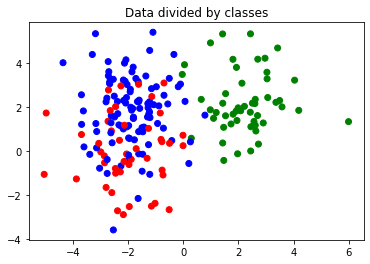

In [11]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer().fit(Y)
Y_scaled1 = transformer.transform(Y)

colormap = np.array(['r', 'g', 'b'])
y1, y2 = np.array(Y[:, 0]), np.array(Y[:, 1])
plt.scatter(y1, y2, c=colormap[X])
plt.title('Data divided by classes')
plt.show()

#for y in Y_scaled:
#    print(np.linalg.norm(y))

Epsilon: 0.2
Initialization
[[ 0.45550949 -1.1821094 ]
 [-0.9217376  -0.43763163]
 [ 1.17602774 -0.7703629 ]]


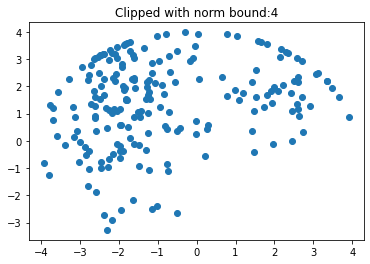

Maximum Iterations Done
Iterations Required: 7
Total eps/delta (856.6965167239873, 0.32)
Total privacy mechanisms 63


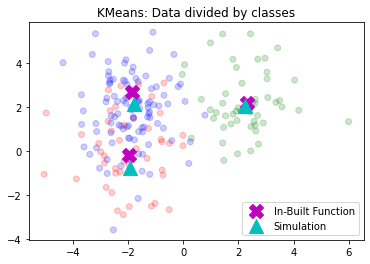

Private KMeans DONE!
LL -889.1918340936037123
LL -887.2278265751186107
LL -904.9161537282931401
LL -895.6454964795478083
LL -887.2023336666412064
LL -868.59659710220582696
LL -844.6315564569779433
Total Privacy Cost: (2699.7233497027682, 1.025)
No. of Iterations required: 7


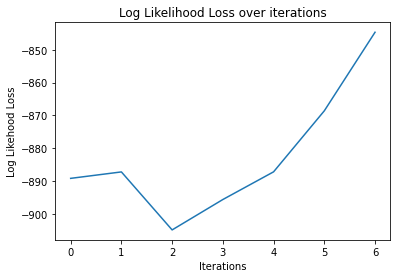

Final Private Parameters
[[-1.23822511 -0.26226721]
 [-1.65423062  1.65008573]
 [ 1.77223096  1.64696659]]
[[[ 1.88460535  0.85489485]
  [ 0.81935458  2.2251014 ]]

 [[ 0.69373615  0.57245015]
  [ 0.53132297  1.02822505]]

 [[ 1.01139038  0.00232889]
  [-0.007082    0.57258143]]]
[0.22269285 0.55595352 0.22135363]
Accuracy: 0.135
[1 1 1 1 1 1 1 0 1 2 1 1 2 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 2 0 0
 1 1 1 1 1 1 1 1 2 2 2 1 1 2 2 1 1 1 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 1 2 1 2
 1 1 0 0 1 2 1 1 2 0 1 1 1 2 1 0 1 2 0 0 1 1 0 0 0 0 2 2 2 2 1 2 1 0 1 2 2
 2 0 2 0 2 2 2 0 1 1 1 1 0 1 0 1 0 0 0 1 2 2 2 2 1 2 2 0 1 0 2 1 0 2 0 1 1
 1 0 0 1 1 0 1 2 1 2 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 0 2 1 1 2 1 1 1
 1 2 2 0 1 1 0 2 0 1 1 1 1 1 1]
Simualted with eps: 0.2


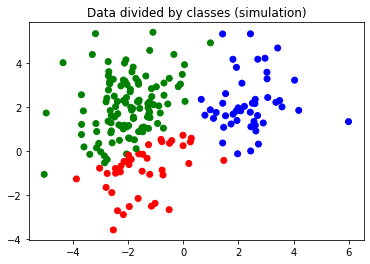

Epsilon: 0.2
Initialization
[[-0.83095242 -0.64799405]
 [-0.72286788  1.5561688 ]
 [ 1.72927123 -0.21955169]]


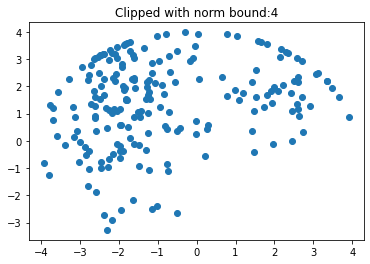

Maximum Iterations Done
Iterations Required: 7
Total eps/delta (134.08947932228256, 0.32)
Total privacy mechanisms 63


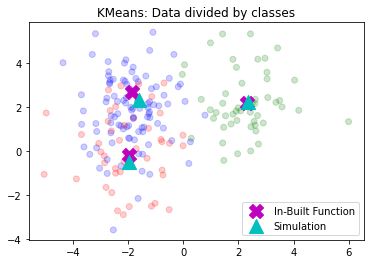

Private KMeans DONE!
LL -894.14212780836346856
LL -906.7222258003636533
LL -906.04740082424337805
LL -909.44746611273166587
LL -897.9695061483719828
LL -880.50412220042010303
LL -844.0821877754558599
Total Privacy Cost: (397.0237236751766, 1.025)
No. of Iterations required: 7


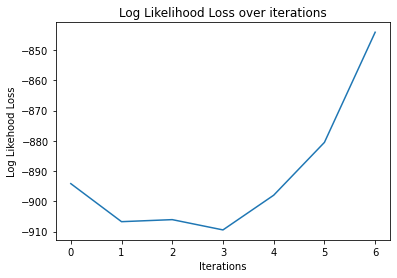

Final Private Parameters
[[-1.54006926 -0.18896524]
 [-1.57208471  1.80002032]
 [ 1.92996439  1.6908169 ]]
[[[ 1.08602149  0.21662517]
  [ 0.23166443  1.99418576]]

 [[ 0.74733243  0.55378369]
  [ 0.53039579  0.87730352]]

 [[ 0.60309609 -0.01938413]
  [-0.14434636  0.47805178]]]
[0.29344407 0.4867386  0.21981733]
Accuracy: 0.16
[1 1 1 1 1 1 1 0 1 2 0 1 2 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 0 2 0 0
 1 1 1 1 1 1 1 1 2 2 2 1 0 2 2 1 1 1 0 1 1 2 2 1 1 2 1 1 1 1 2 2 2 1 2 1 2
 1 1 0 0 1 2 1 1 2 0 1 1 1 2 0 0 1 2 0 0 1 1 0 0 0 0 2 2 2 2 1 2 1 0 1 2 2
 2 0 2 0 2 2 2 0 1 1 1 1 0 1 0 1 0 0 0 1 2 2 2 2 1 2 2 0 0 0 2 1 0 2 0 1 1
 1 0 0 1 1 0 1 2 1 2 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 0 0 2 1 0 2 1 1 1
 1 2 2 0 1 1 0 2 0 1 1 1 1 1 1]
Simualted with eps: 0.2


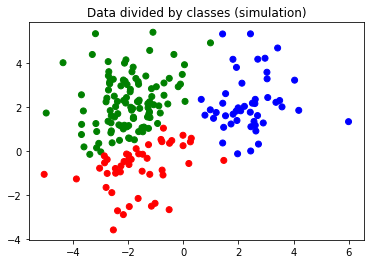

Epsilon: 0.2
Initialization
[[ 0.00138499 -0.54413547]
 [ 1.0178768  -0.13682698]
 [ 0.74673107  1.12574976]]


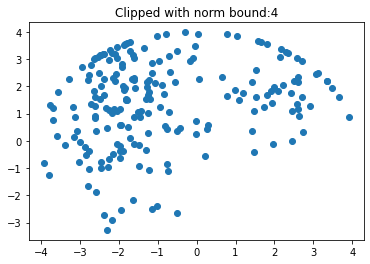

Maximum Iterations Done
Iterations Required: 7
Total eps/delta (33.3535820917354, 0.32)
Total privacy mechanisms 63


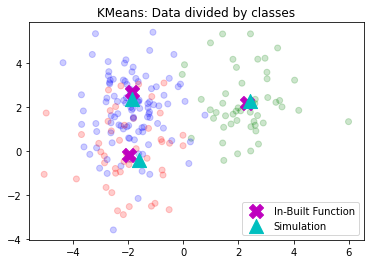

Private KMeans DONE!
LL -889.61163093684626885
LL -881.9346828420159448
LL -880.69219187704342106
LL -894.79437241615289533
LL -880.8189829016526516
Problem with determinant
Sigma: [[0.17478347 0.        ]
 [0.         0.45260278]]
Determinant: 0.07910748294959755
LL -860.92451795938803155
Problem with determinant
Sigma: [[0.54352366 0.        ]
 [0.         0.03423678]]
Determinant: 0.018608499840595386
LL -851.19560633627779
Total Privacy Cost: (89.4166849461788, 1.025)
No. of Iterations required: 7


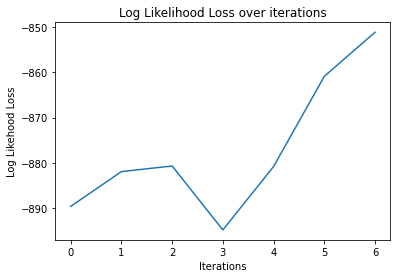

Final Private Parameters
[[ 0.00521503 -2.25438408]
 [-0.26700635  0.12370185]
 [-1.04788183  1.81806455]]
[[[0.54352366 0.        ]
  [0.         0.03423678]]

 [[3.53773504 1.6208542 ]
  [1.4545931  1.67119073]]

 [[1.89462949 0.34252638]
  [0.30131186 0.52955796]]]
[0.01671516 0.37541178 0.60787306]
Accuracy: 0.605
[2 2 2 2 2 2 2 1 2 1 1 2 2 2 1 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 0 2 1 1
 1 2 2 2 2 2 2 2 2 1 1 2 1 1 1 2 2 2 2 2 2 2 1 2 2 1 2 2 2 2 2 1 2 2 2 2 1
 2 2 1 1 2 1 2 2 1 1 2 2 2 2 1 0 2 2 1 1 2 2 1 1 1 1 1 1 1 1 2 1 2 1 2 2 1
 1 1 2 1 2 2 1 1 2 2 2 2 1 2 1 2 1 1 1 2 1 1 1 1 2 2 1 1 1 1 1 2 1 1 1 2 2
 2 1 1 2 2 1 2 1 2 2 1 2 2 2 2 1 2 2 1 2 2 2 2 2 1 2 2 2 1 1 1 2 1 1 2 2 2
 2 1 1 1 2 2 1 2 1 2 2 2 2 2 2]
Simualted with eps: 0.2


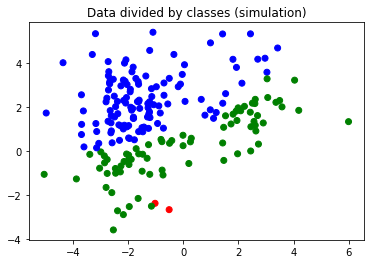

Epsilon: 0.2
Initialization
[[ 1.37810047 -0.87286019]
 [ 0.77444284  1.79487135]
 [-0.62511584 -0.09140651]]


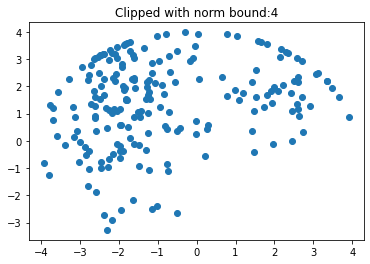

Maximum Iterations Done
Iterations Required: 7
Total eps/delta (7.957219578690685, 0.32)
Total privacy mechanisms 63


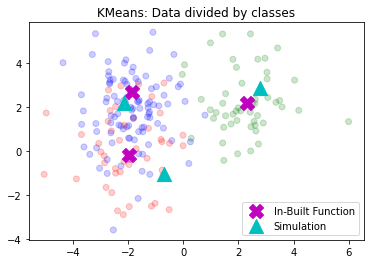

Private KMeans DONE!
LL -888.33188019570986554
Problem with determinant
Sigma: [[0.86124118 0.        ]
 [0.         0.50137555]]
Determinant: 0.43180527138393876
LL -898.28565988961074623
Problem with determinant
Sigma: [[0.09442072 0.        ]
 [0.         0.85476498]]
Determinant: 0.0807075226358407
LL -958.47877378471156107
LL -855.95325110045553635
LL -866.62278329753281575
LL -916.9054593711515724
LL -882.52002446925769424
Total Privacy Cost: (18.33207866684122, 1.025)
No. of Iterations required: 7


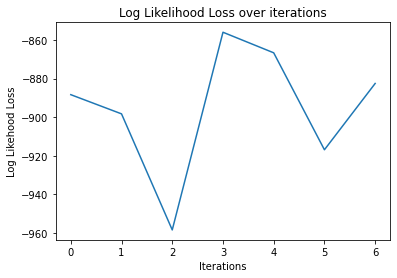

Final Private Parameters
[[-0.05623727 -0.71417383]
 [-0.45953535  1.76186163]
 [-1.22591471  0.91195449]]
[[[ 0.70051611  0.44843376]
  [ 1.79656174  2.23434998]]

 [[ 2.60998087 -0.10549787]
  [-0.19690322  0.90171083]]

 [[ 2.07077159  0.75097437]
  [ 0.94331165  2.3014192 ]]]
[0.09788397 0.55240225 0.34971378]
Accuracy: 0.39
[2 1 1 1 1 1 1 2 1 1 2 1 1 1 2 1 1 1 1 2 2 1 1 1 1 1 1 1 1 2 1 1 1 0 1 1 1
 2 1 1 1 1 1 1 2 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1
 1 1 2 0 1 1 2 1 1 2 1 1 1 1 2 0 2 1 2 2 1 1 0 0 2 0 1 1 1 1 1 1 2 2 1 1 1
 1 1 1 2 1 1 1 2 2 1 2 1 2 1 2 1 0 2 2 2 1 1 1 1 1 1 1 0 2 2 1 1 2 1 1 1 1
 1 1 2 1 1 2 1 1 1 1 2 1 1 1 1 2 1 1 2 1 1 1 1 2 2 1 1 1 2 0 1 1 2 1 1 1 1
 1 1 1 2 1 1 0 1 1 1 1 1 2 1 1]
Simualted with eps: 0.2


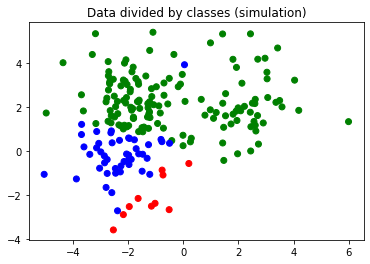

In [12]:


gmm_em_private = GMM_EM(N_classes, data, Y, X, d=2, max_iters = 7, private=True, clip_bound = 4, eps = 2, delta = 1./200, tol=0.0001)
gmm_em_private.run_EM()
print('Final Private Parameters')
print(gmm_em_private.means)
print(gmm_em_private.covs)
print(gmm_em_private.priors)
proba_sim_private = gmm_em_private.E_step()
proba_labels_sim_private = np.argmax(proba_sim_private, 1)
print('Accuracy:', np.mean(np.argmax(proba_sim_private, 1) ==  X))

# Private

#print(proba_sim_private)
print(np.argmax(proba_sim_private, 1))

print('Simualted with eps:', 0.2)
colormap = np.array(['r', 'g', 'b'])
lab = np.array(list(map(int, proba_labels_sim_private)))
plt.scatter(y1, y2, c=colormap[lab])
plt.title('Data divided by classes (simulation)')
plt.show()

gmm_em_private = GMM_EM(N_classes, data, Y, X, d=2, max_iters = 7, private=True, clip_bound = 4, eps = 1, delta = 1./200, tol=0.0001)
gmm_em_private.run_EM()
print('Final Private Parameters')
print(gmm_em_private.means)
print(gmm_em_private.covs)
print(gmm_em_private.priors)
proba_sim_private = gmm_em_private.E_step()
proba_labels_sim_private = np.argmax(proba_sim_private, 1)
print('Accuracy:', np.mean(np.argmax(proba_sim_private, 1) ==  X))

# Private

#print(proba_sim_private)
print(np.argmax(proba_sim_private, 1))

print('Simualted with eps:', 0.2)
colormap = np.array(['r', 'g', 'b'])
lab = np.array(list(map(int, proba_labels_sim_private)))
plt.scatter(y1, y2, c=colormap[lab])
plt.title('Data divided by classes (simulation)')
plt.show()

gmm_em_private = GMM_EM(N_classes, data, Y, X, d=2, max_iters = 7, private=True, clip_bound = 4, eps = 0.5, delta = 1./200, tol=0.0001)
gmm_em_private.run_EM()
print('Final Private Parameters')
print(gmm_em_private.means)
print(gmm_em_private.covs)
print(gmm_em_private.priors)
proba_sim_private = gmm_em_private.E_step()
proba_labels_sim_private = np.argmax(proba_sim_private, 1)
print('Accuracy:', np.mean(np.argmax(proba_sim_private, 1) ==  X))

# Private

#print(proba_sim_private)
print(np.argmax(proba_sim_private, 1))

print('Simualted with eps:', 0.2)
colormap = np.array(['r', 'g', 'b'])
lab = np.array(list(map(int, proba_labels_sim_private)))
plt.scatter(y1, y2, c=colormap[lab])
plt.title('Data divided by classes (simulation)')
plt.show()

gmm_em_private = GMM_EM(N_classes, data, Y, X, d=2, max_iters = 7, private=True, clip_bound = 4, eps = 0.2, delta = 1./200, tol=0.0001)
gmm_em_private.run_EM()
print('Final Private Parameters')
print(gmm_em_private.means)
print(gmm_em_private.covs)
print(gmm_em_private.priors)
proba_sim_private = gmm_em_private.E_step()
proba_labels_sim_private = np.argmax(proba_sim_private, 1)
print('Accuracy:', np.mean(np.argmax(proba_sim_private, 1) ==  X))

# Private

#print(proba_sim_private)
print(np.argmax(proba_sim_private, 1))

print('Simualted with eps:', 0.2)
colormap = np.array(['r', 'g', 'b'])
lab = np.array(list(map(int, proba_labels_sim_private)))
plt.scatter(y1, y2, c=colormap[lab])
plt.title('Data divided by classes (simulation)')
plt.show()

[0.41374837 0.1940379  0.39221373]
LL -874.8840999271137987
Singular Value Error
Inv Sigma: [[1.95593733 0.        ]
 [0.         1.61024959]]
LL -879.70452074229272466
LL -883.8297721733582525
LL -885.68456161915776526
Singular Value Error
Inv Sigma: [[4.93282399 0.        ]
 [0.         2.69157911]]
LL -886.6267868207653972
LL -887.4308642701047468
Singular Value Error
Inv Sigma: [[6.4141936  0.        ]
 [0.         3.17817253]]
LL -888.09615886812879887
LL -888.59445244187342766
Problem with determinant
Sigma: [[0.1089295  0.        ]
 [0.         0.31549007]]
Determinant: 0.034366175744605425
LL -888.959408195783023
LL -889.2285532556667504
Singular Value Error
Inv Sigma: [[8.10664751 0.        ]
 [0.         1.63105454]]
LL -889.4286648135376353
LL -889.57827651632734406
Singular Value Error
Inv Sigma: [[1.60707844 0.        ]
 [0.         3.67803365]]
LL -889.6905584784054716
LL -889.77505901262013094
Singular Value Error
Inv Sigma: [[1.13178028 0.        ]
 [0.         3.073090

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:116: RuntimeWarning: overflow encountered in exp


LL inf
LL -893.5092231746899207
LL -889.26792440947330837
Singular Value Error
Inv Sigma: [[1.02419967 0.        ]
 [0.         4.10267771]]
LL -895.65161205311069403
LL -894.7304682646236439
LL -894.4168406536308935
LL -893.3952959011549673
LL -873.80906451646817695
Singular Value Error
Inv Sigma: [[5.66926757 0.        ]
 [0.         3.65298923]]
LL -895.7460237517852948
LL -893.8120381136394218
LL -889.9063063735741911
Singular Value Error
Inv Sigma: [[2.92491032 0.        ]
 [0.         8.03239904]]
LL -895.5842885241257916
LL -894.0681550982842468
LL -889.4833056974683572
Singular Value Error
Inv Sigma: [[1.20700053 0.        ]
 [0.         1.10813394]]
LL -895.8939827269212147
LL -894.84875111375078655
LL -894.4131189621789517
LL -894.1373608131478483
LL -893.52269208941788625
LL -881.7441042036027373
LL -861.3292603246941993
Singular Value Error
Inv Sigma: [[7.88327309 0.        ]
 [0.         1.27982761]]
LL -895.92088142151183167
LL -894.05873581695405283
LL -892.6756450135547

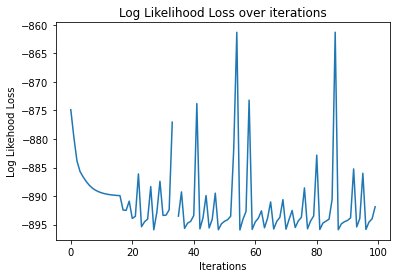

Final Parameters
[[ 2.14445295  2.14477763]
 [-4.57202495 -1.14013919]
 [-1.91841006  1.30345032]]
[[[ 1.31209596  0.12938461]
  [ 0.12938461  1.86087553]]

 [[ 0.3286244  -0.05881323]
  [-0.05881323  0.01060229]]

 [[ 0.88347339  0.0227381 ]
  [ 0.0227381   3.17735184]]]
[0.26463536 0.00823878 0.72712586]
Accuracy: 0.51


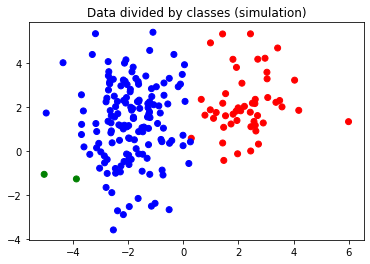

In [13]:
# Try with a random initialization, Gives poor results & takes way longer
N_classes = 3
gmm_em = GMM_EM(N_classes, data, Y, X, d=2, max_iters=100, tol=0.0001)
n_classes, d = 3, 2
P = np.random.random(n_classes)
gmm_em.priors = P/np.sum(P)
#gmm_em.priors = np.array([1./n_classes for _ in range(n_classes)])
print(gmm_em.priors)
gmm_em.means = np.random.uniform(-20, 20, n_classes*d).reshape(n_classes, d)
gmm_em.covs = np.array([np.eye(d)*np.random.random(d) for _ in range(n_classes)])
#print(np.eye(d)*np.random.uniform(1, 10, 2))
gmm_em.run_EM()
print('Final Parameters')
print(gmm_em.means)
print(gmm_em.covs)
print(gmm_em.priors)
proba_sim = gmm_em.E_step()
proba_labels_sim = np.argmax(proba_sim, 1)
print('Accuracy:', np.mean(np.argmax(proba_sim, 1) ==  X))

colormap = np.array(['r', 'g', 'b'])
lab = np.array(list(map(int, proba_labels_sim)))
plt.scatter(y1, y2, c=colormap[lab])
plt.title('Data divided by classes (simulation)')
plt.show()

LL -993.9772185363634427
LL -993.04833060740172035
LL -992.6805230493059967
LL -992.50388480319679263
LL -992.4079175547761718
LL -992.35071726836455136
LL -992.31391908194722806
No. of Iterations required: 7


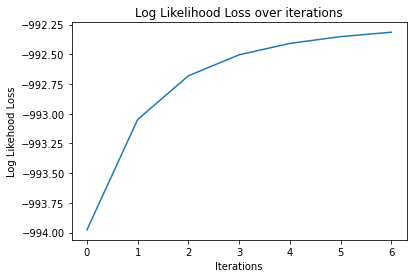

Final Parameters
[[-1.80285923  2.42265228]
 [-2.07100084  0.08733736]
 [ 2.19170049  2.14718609]]
[[[ 0.86604919 -0.08763105]
  [-0.08763105  1.42512914]]

 [[ 1.05746326 -0.0200051 ]
  [-0.0200051   2.26849957]]

 [[ 1.22713154  0.1319484 ]
  [ 0.1319484   1.86720372]]]
[0.37896578 0.36197574 0.25905848]
0.065
True Parameters
[[ 2.19853835  2.1476146 ]
 [-2.0593749   0.07402729]
 [-1.80933359  2.44118961]]
[[[ 1.21504424  0.13171905]
  [ 0.13171905  1.86544026]]

 [[ 1.06034715 -0.00834307]
  [-0.00834307  2.21823842]]

 [[ 0.87430621 -0.07953249]
  [-0.07953249  1.39772044]]]
[0.25824606 0.36305577 0.37869817]
True
Iters Required 6
0.34
In-Built


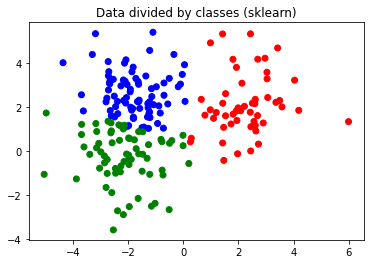

Simulation


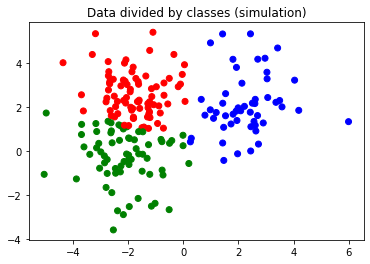

18
Privacy Budget: 81.0 0.09
0.03
Simulation Private


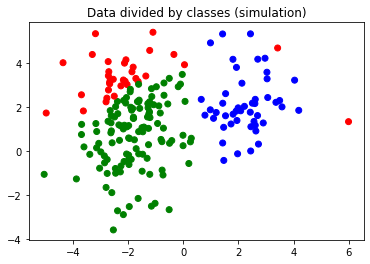

In [14]:
N_classes = 3
gmm_em = GMM_EM(N_classes, data, Y, X, d=2, max_iters=7)
gmm_em.run_EM()
print('Final Parameters')
print(gmm_em.means)
print(gmm_em.covs)
print(gmm_em.priors)
proba_sim = gmm_em.E_step()
proba_labels_sim = np.argmax(proba_sim, 1)
print(np.mean(np.argmax(proba_sim, 1) ==  X))



print('True Parameters')
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3)
gm = gm.fit(Y)
print(gm.means_)         
print(gm.covariances_)
print(gm.weights_)
print(gm.converged_)
print('Iters Required', gm.n_iter_)
proba_sklearn = gm.predict_proba(Y)
proba_labels_sklearn = np.argmax(proba_sklearn, 1)
print(np.mean(np.argmax(proba_sklearn, 1) ==  X))

# In-Built
print('In-Built')
colormap = np.array(['r', 'g', 'b'])
lab = np.array(list(map(int, proba_labels_sklearn)))

plt.scatter(y1, y2, c=colormap[lab])
plt.title('Data divided by classes (sklearn)')
plt.show()

# True simulation
print('Simulation')
colormap = np.array(['r', 'g', 'b'])
lab = np.array(list(map(int, proba_labels_sim)))
plt.scatter(y1, y2, c=colormap[lab])
plt.title('Data divided by classes (simulation)')
plt.show()

eps_model = 4.5
# Private Last Model
counts = 0
for k in range(3):
    gmm_em.means[k, :]+=add_noise(eps_model, 1./200, sensitivity=np.sqrt(6), size=2)
    gmm_em.priors[k]+=(add_noise(eps_model, 1./200, sensitivity=1, size=1))
    gmm_em.covs[k, :]+=(add_noise(eps_model, 1./200, sensitivity=6, size=(2, 2)))
    counts+=6
gmm_em.priors = np.abs(gmm_em.priors)
#gmm_em.covs = np.abs(gmm_em.covs)
gmm_em.priors/=np.sum(gmm_em.priors)
print(counts)
eps1, delta1 = advanced_composition(eps_model, 1./200, counts)
print('Privacy Budget:', min(counts*eps_model, eps1), min(1./200*counts, delta1))

proba_sim_private = gmm_em.E_step()
proba_labels_sim_private = np.argmax(proba_sim_private, 1)
print(np.mean(np.argmax(proba_sim_private, 1) ==  X))

# True simulation
print('Simulation Private')
colormap = np.array(['r', 'g', 'b'])
lab = np.array(list(map(int, proba_labels_sim_private)))
plt.scatter(y1, y2, c=colormap[lab])
plt.title('Data divided by classes (simulation)')
plt.show()